In [1]:
# This class tests whether the tensorflow and autograd versions give identical outputs for a simple least squared loss function

In [1]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from optimizers.autograd.curveball import Curveball as agCb
from optimizers.tensorflow.curveball import Curveball as tfCb

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
z_true = np.random.randn(3,100).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [4]:
def y_pred(z_flat):
    z_arr = np.reshape(z_flat, (3, -1))
    return (affine_transform @ z_arr).flatten()

def loss_fn(y):
    return 0.5 * np.sum((y - y_true_flat)**2)

In [5]:
z_guess = np.random.randn(300).astype('float32')

In [6]:
# Testing the autograd implementations

In [7]:
cb_ag1 = agCb(z_guess, y_pred, loss_fn, squared_loss=True)
cb_ag2 = agCb(z_guess, y_pred, loss_fn, squared_loss=False)

In [8]:
ag_losses1 = []
ag_losses2 = []
for i in range(50):
    out1 = cb_ag1.minimize()
    lossval = loss_fn(y_pred(out1))
    out2 = cb_ag2.minimize()
    ag_losses1.append(loss_fn(y_pred(out1)))
    ag_losses2.append(loss_fn(y_pred(out2)))

In [10]:
# Tensorflow test

In [11]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2)

preds1 = tf_y_pred(var1)
preds2 = tf_y_pred(var2)
loss_tensor1 = tf_loss(preds1)
loss_tensor2 = tf_loss(preds2)

ct1 = tfCb(var1, tf_y_pred, tf_loss, name='opt1', squared_loss=True)
ct2 = tfCb(var2, tf_y_pred, tf_loss, name='opt2', squared_loss=False)

ct1_min = ct1.minimize()
ct2_min = ct2.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())

In [12]:
tf_losses1 = []
tf_losses2 = []
for i in range(50):
    session.run([ct1_min, ct2_min])
    lossval1, lossval2 = session.run([loss_tensor1, loss_tensor2])
    tf_losses1.append(lossval1)
    tf_losses2.append(lossval2)
    

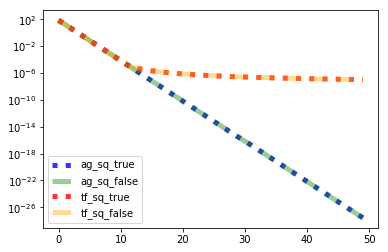

In [13]:
# Any discrepancy here is because curveball requires a matrix inversion step
# the matrix becomes singular fairly often
# I tried calculating the pseudo inverse myself, but all the approach I tried for this 
# in tensorflow game solutions less stable and accurate than the numpy counterpart.

plt.plot(ag_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag_sq_true')
plt.plot(ag_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='ag_sq_false')
plt.plot(tf_losses1, color='red', ls=':', linewidth=5.0, alpha=0.8, label='tf_sq_true')
plt.plot(tf_losses2, color='orange', ls='--', linewidth=5.0, alpha=0.4, label='tf_sq_false')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [13]:
print(ag_losses1[:10], tf_losses2[:10])

[80.65141471644594, 20.162853679111503, 5.040713419777873, 1.2601783549444696, 0.31504458873611735, 0.07876114718402924, 0.01969028679600733, 0.004922571699001818, 0.0012306429247504504, 0.00030766073118761525] [80.65143, 20.142689, 5.030636, 1.2564014, 0.31378698, 0.07836899, 0.019573405, 0.0048892046, 0.0012218212, 0.00030589764]
